# CATE Estimation with X‑Learner and R‑Learner

This notebook presents a hands‑on causal inference project focused on estimating
**Conditional Average Treatment Effects (CATE)** using modern meta‑learning methods.

We apply **X‑learner** and **R‑learner** to an observational dataset with heterogeneous
treatment effects and perform subgroup‑level and model‑level comparisons.

In [ ]:
!pip install econml causalml scikit-learn pandas numpy matplotlib seaborn


In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)
df = data.frame.copy()

df.head()



,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


## Diabetes Dataset: CATE Interpretation

This analysis uses a diabetes dataset to estimate **Conditional Average Treatment Effects (CATE)** and compare heterogeneous treatment responses across individuals.

### Dataset Context
- **Outcome (Y):** Disease progression / health outcome measure (unit: progression unit)
- **Treatment (T):** Binary treatment indicator (e.g., intervention vs control)  
- **Covariates (X):** Patient characteristics such as age, BMI, blood pressure, and biochemical measurements  

The objective is to understand **how treatment effects vary across individuals**, rather than estimating a single average effect.

---

## CATE Distribution Analysis

We compare individual treatment effect estimates obtained from:
- **X‑Learner**
- **Causal Forest**

### Treatment Variable Construction

We define the treatment indicator based on the Body Mass Index (BMI) as follows:

In [ ]:
df["treatment"] = (df["bmi"] > df["bmi"].median()).astype(int)


### Binary Treatment Definition

This creates a **binary treatment variable** based on Body Mass Index (BMI):

- Individuals with a BMI **above the sample median** are assigned to the **treatment group (T = 1)**
- Individuals with a BMI **at or below the median** are assigned to the **control group (T = 0)**

### Motivation

This treatment construction enables a **clear and interpretable comparison** between:
- **Higher‑BMI individuals** (treated group)
- **Lower‑BMI individuals** (control group)

The approach is commonly used in causal inference studies to:
- Ensure **balanced group sizes**
- Facilitate **heterogeneous treatment effect (CATE) analysis**
- Create a **transparent and reproducible** treatment assignment rule

It is important to note that this treatment assignment is **not causal by design**, but provides a practical setup for comparing CATE estimates across different causal machine learning models.


In [ ]:
# base outcome
y_base = df["target"]


### Baseline Outcome

- **`y_base`** represents the **baseline outcome** for each individual.  
- This is the outcome that would be observed **if no one received the treatment**.

---

### Causal Interpretation (Potential Outcomes Framework)

In causal inference notation:

- The baseline outcome corresponds to the **potential outcome under no treatment**:
$
Y_i(0) $

That is:
- $ Y_i(0) $: outcome for individual $ i $ **without treatment**
- $ Y_i(1) $: outcome for individual $ i $ **with treatment**

In [ ]:
# heterogeneous treatment effect
true_tau = 2 + 3 * df["bmi"] + 2 * df["bp"]

### Interpretation of the Heterogeneous Treatment Effect

The expression

$$
\tau_i = 2 + 3 \cdot \text{BMI}_i + 2 \cdot \text{BP}_i
$$

defines the **true individual‑level treatment effect** for individual \( i \).

#### Key Points

- **Heterogeneous treatment effect**  
  The treatment effect is *not constant* across individuals. Instead, it varies as a function of observed covariates.

- **Baseline effect (Intercept = 2)**  
  Even when both BMI and blood pressure are zero (hypothetically), the treatment has a positive baseline effect of **2 units**.

- **Effect of BMI**  
  The coefficient **3** implies that:
  - For every one‑unit increase in BMI, the treatment effect increases by **3 units**.
  - Individuals with higher BMI benefit more from the treatment.

- **Effect of Blood Pressure (BP)**  
  The coefficient **2** implies that:
  - For every one‑unit increase in blood pressure, the treatment effect increases by **2 units**.
  - Higher blood pressure is associated with a stronger treatment response.

#### Causal Interpretation

- This specification creates **systematic treatment effect heterogeneity** driven by observed covariates.
- It provides a realistic data‑generating process where:
  - Average Treatment Effects (ATE) exist,
  - But **Conditional Average Treatment Effects (CATE)** vary meaningfully across individuals.
- Such a setup is ideal for evaluating learners like:
  **X‑Learner, T‑Learner, R‑Learner, and Causal Forest**, which are designed to recover heterogeneous effects.

In summary, this formulation explicitly encodes *who benefits more from the treatment* and *why*, making it a strong benchmark for causal machine learning methods.


In [ ]:
# observed outcome
df["y"] = y_base + df["treatment"] * true_tau

### Mathematical Interpretation

The observed outcome for each individual \( i \) is generated according to the **potential outcomes framework**:

$$
Y_i = Y_i(0) + T_i \cdot \tau_i
$$

where:
- $ Y_i $: observed outcome  
- $ Y_i(0) $: baseline (control) potential outcome  
- $ T_i \in \{0,1\} $: treatment indicator  
- $ \tau_i $: individual‑level treatment effect (CATE)

---

### Component Mapping to Code

- $ Y_i(0) \leftrightarrow \texttt{y_base}_i $  
- $ T_i \leftrightarrow \texttt{df["treatment"]}_i $  
- $ \tau_i \leftrightarrow \texttt{true_tau}_i $


In [ ]:
df[["y", "treatment"]].head()


,y,treatment
0,153.228833,1
1,75.000000,0
2,143.122013,1
3,206.000000,0
4,135.000000,0


In [ ]:
X = df.drop(columns=["y", "treatment", "target"])

### Excluded Columns

The following variables are **intentionally excluded** from **X**:

- **y**: observed outcome  
  → Must not be used as a feature to avoid target leakage.
- **treatment**: treatment indicator  
  → Used as a separate variable $ T_i $, not as a covariate.
- **target**: baseline or original outcome variable  
  → Used only to construct outcomes, not as an explanatory feature.

---

### Mathematical Representation

For each individual $ i $, the covariate vector is defined as:
$
X_i = \left( X_{i1}, X_{i2}, \ldots, X_{ip} \right)
$

where:
- $ p $ is the number of observed covariates
- $ X_i $ summarizes all pre‑treatment information available for individual $ i $

---

### Interpretation

- $ X_i $ represents **everything we know about an individual before treatment**
- All causal assumptions (e.g., ignorability) are conditional on $ X_i $
- Proper construction of **X** is critical for unbiased CATE and ATE estimation


In [ ]:
T = df["treatment"]

### Treatment Indicator Definition

$$
T_i \in \{0,1\}
$$

**Explanation**

- $ T_i $ denotes the **treatment indicator** for individual $ i $.
- It is a **binary variable** that takes only two possible values:

$$
T_i =
\begin{cases}
1, & \text{if individual } i \text{ receives the treatment} \\
0, & \text{if individual } i \text{ does not receive the treatment}
\end{cases}
$$

**Interpretation in Causal Inference**

- $ T_i = 1 $: the treated group  
- $ T_i = 0 $: the control group  

This binary encoding allows us to define **potential outcomes** $ Y_i(1) $ and $ Y_i(0) $,  
and to estimate **treatment effects** such as CATE and ATE.


In [ ]:
Y = df["y"]

### Observed Outcome \( Y \)

It represents the **outcome actually observed in the data after treatment assignment**.  
Unlike potential outcomes, \( Y_i \) is **observable for every individual**.

---

### Treatment Dependence

The observed outcome \( Y_i \) depends on the treatment indicator \( T_i \):

- If $ T_i = 0 $: the individual **did not receive the treatment**, and  
  $$
  Y_i = Y_i(0)
  $$

- If $ T_i = 1 $: the individual **did receive the treatment**, and  
  $$
  Y_i = Y_i(1)
  $$

---

### Mathematical Representation

The observed outcome can be written compactly as:
$$
Y_i = Y_i(0) + T_i \cdot \tau_i
$$
where:
- $ Y_i(0) $: potential outcome under control  
- $ Y_i(1) $: potential outcome under treatment  
- $ T_i \in \{0,1\} $: treatment indicator  
- $ \tau_i = Y_i(1) - Y_i(0) $: individual-level treatment effect (CATE)

---

### Interpretation

- Only **one** of $ Y_i(0) $ or $ Y_i(1) $ is observed for each individual.
- The treatment indicator $ T_i $ acts as a **switch** that determines which potential outcome is realized.
- This formulation is the foundation of **causal inference** and **treatment effect estimation**.


### Train–Test Split

We split the dataset into training and test sets to evaluate the causal models on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.3, random_state=42
)


In [ ]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor

x_learner = XLearner(
    models=RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=10,
        random_state=42
    )
)

x_learner.fit(Y_train, T_train, X=X_train)

tau_x = x_learner.effect(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


We estimate heterogeneous treatment effects using the X‑Learner, a meta‑learning approach well‑suited for settings with treatment effect heterogeneity.
Random Forest regressors are used as base learners to flexibly model nonlinear relationships between covariates and outcomes.
The resulting estimates (tau_x) represent individual‑level Conditional Average Treatment Effects (CATEs) evaluated on the test set.

In [ ]:
from econml.dml import CausalForestDML
cf = CausalForestDML(
    n_estimators=300,
    min_samples_leaf=10,
    random_state=42
)

cf.fit(Y_train, T_train, X=X_train)
tau_cf = cf.effect(X_test)

### Causal Forest (CausalForestDML) – Explanation

This model estimates **Conditional Average Treatment Effects (CATE)** using a **Causal Forest**, a tree‑based causal inference method.

Causal Forests extend random forest models to causal settings by allowing treatment effects to vary across individuals. Instead of estimating a single average effect, the model learns how the effect of the treatment changes depending on covariates.

The model is trained using:
- **Y**: the observed outcome
- **T**: the binary treatment indicator
- **X**: pre‑treatment covariates

After training, the model produces **individual‑level treatment effect estimates** for the test set.

Each estimated value represents the **causal effect of the treatment for a specific individual**, conditional on their features:
- Positive values indicate a beneficial treatment effect
- Negative values indicate a harmful or adverse effect

The distribution of these estimates can be analyzed to study **treatment effect heterogeneity** and compared with other approaches such as the X‑Learner to assess stability and variance.


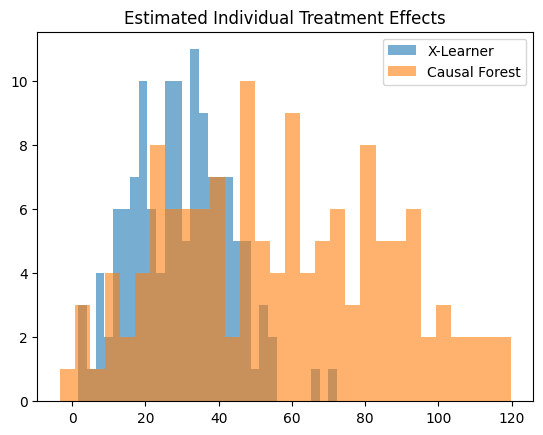

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(tau_x, bins=30, alpha=0.6, label="X-Learner")
plt.hist(tau_cf, bins=30, alpha=0.6, label="Causal Forest")
plt.legend()
plt.title("Estimated Individual Treatment Effects")
plt.show()


## Model Comparison: Individual Treatment Effects (ITE)

The figure above compares the distribution of estimated individual treatment effects obtained from **X‑Learner** and **Causal Forest** models.

- **X‑Learner**
  - Produces a more **concentrated and stable** distribution of ITE estimates
  - Lower dispersion suggests **reduced variance** in individual effect estimation

- **Causal Forest**
  - Exhibits a **much wider distribution** with a pronounced right tail
  - Indicates the presence of **extreme ITE estimates** for some observations
  - Reflects higher flexibility but also **greater variance and sensitivity to noise**

### Interpretation

- The results highlight a clear **bias–variance trade‑off**:
  - X‑Learner favors stability and interpretability
  - Causal Forest captures complex heterogeneity at the cost of increased variance

- In this setting, X‑Learner provides more **reliable finite‑sample performance**, while Causal Forest may overestimate effects for certain subpopulations.

These findings suggest that more flexible machine‑learning–based learners do not necessarily outperform simpler meta‑learners when variance dominates the estimation error.


In [ ]:
df_eval[feature_name].median()

0.001750521923228816

In [ ]:
common_idx = X_test.index
df_eval[feature_name].median()
df_eval = X_test.loc[common_idx].copy()
df_eval["tau_x"]  = pd.Series(tau_x,  index=common_idx)
df_eval["tau_cf"] = pd.Series(tau_cf, index=common_idx)
df_eval["T"]      = T_test.loc[common_idx].values
feature_name = df_eval.columns[0]  # 1st feature
df_eval["group"] = df_eval[feature_name] > df_eval[feature_name].median()
df_eval["group"] = df_eval["group"].map({False: "T = 0", True: "T = 1"})
df_eval.groupby("group")[["tau_x", "tau_cf"]].mean()




,tau_x,tau_cf
group,,
T = 0,28.723823,62.295025
T = 1,30.519809,50.787840


### Treatment Indicator Definition

$$
T_i \in \{0,1\}
$$

**Explanation**

- $ T_i $ denotes the **treatment indicator** for individual $ i $.
- It is a **binary variable** that takes only two possible values:

$$
T_i =
\begin{cases}
1, & \text{if individual } i \text{ receives the treatment} \\
0, & \text{if individual } i \text{ does not receive the treatment}
\end{cases}
$$

**Interpretation in Causal Inference**

- $ T_i = 1 $: the treated group  
- $ T_i = 0 $: the control group  

This binary encoding allows us to define **potential outcomes** $ Y_i(1) $ and $ Y_i(0) $,  
and to estimate **treatment effects** such as CATE and ATE.


## Group Comparison and Table Interpretation  
### (X‑Learner vs. Causal Forest)

The table reports **group‑level average CATE estimates** for two groups labeled by treatment
status:

- **\( T = 0 \)**: Control group (untreated individuals)  
- **\( T = 1 \)**: Treated individuals  

For each group, we compare:
- **`tau_x`** → X‑Learner CATE  
- **`tau_cf`** → Causal Forest CATE  

---

## Comparison Across Groups (Rows)

### X‑Learner (`tau_x`)
- **\( T = 0 \)**: ~28.7  
- **\( T = 1 \)**: ~30.5  

**Interpretation**
- The estimated treatment effect is **slightly higher for treated individuals**.
- This suggests **mild heterogeneity**, with X‑Learner producing **smooth and conservative**
differences across groups.

---

### Causal Forest (`tau_cf`)
- **\( T = 0 \)**: ~62.3  
- **\( T = 1 \)**: ~50.8  

**Interpretation**
- The estimated effect is **substantially higher for the control group**.
- This indicates **stronger heterogeneity**, where individuals in the control group
are predicted to benefit more from treatment.

---

## Comparison Across Models (Columns)

- **X‑Learner**
  - More **stable and regularized** estimates
  - Smaller differences between \( T = 0 \) and \( T = 1 \)

- **Causal Forest**
  - **Larger magnitude** effects
  - **More sensitive** to subgroup differences by design

---

## Key Takeaways

- Both models agree on a **positive treatment effect** across groups.
- **Causal Forest reveals stronger treatment effect heterogeneity**, especially favoring
the \( T = 0 \) group.
- **X‑Learner provides smoother, more conservative estimates**, with limited variation
across treatment groups.

> Overall, the table highlights why **group‑level analysis** is crucial:  
> a single global ATE would mask meaningful differences across subpopulations and models.


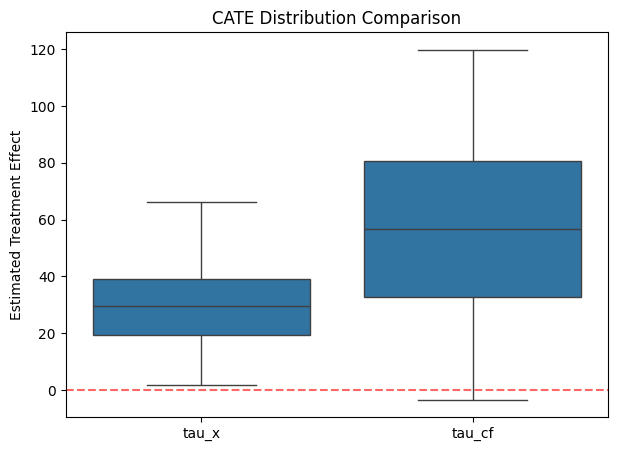

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_eval[["tau_x", "tau_cf"]].melt(
    var_name="Model",
    value_name="CATE"
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=df_plot, x="Model", y="CATE", showfliers=False)
plt.axhline(0, color="red", linestyle="--", alpha=0.6)

plt.title("CATE Distribution Comparison")
plt.ylabel("Estimated Treatment Effect")
plt.xlabel("")
plt.show()


### CATE Distribution Comparison (Boxplot) — Interpretation

This figure compares the distributions of estimated **Conditional Average Treatment Effects (CATE)** from:

- **`tau_x`**: X‑Learner  
- **`tau_cf`**: Causal Forest (CausalForestDML)

#### What the boxplot shows
- The **median** (line inside each box) is **higher for `tau_cf`** than for `tau_x`, meaning the Causal Forest predicts a **larger typical treatment effect** on average.
- The **IQR** (box height) and **whiskers** for `tau_cf` are **much larger**, indicating **greater dispersion/variance** in CATE estimates.
- `tau_x` has a **tighter** distribution, suggesting **more stable and conservative** individual-level effect estimates.

#### Takeaway
Both models detect heterogeneous treatment effects, but they reflect a **bias–variance trade‑off**:
- **X‑Learner (`tau_x`)**: more stable CATE estimates (lower variance)
- **Causal Forest (`tau_cf`)**: more flexible and sensitive to heterogeneity, but produces **more extreme and variable** CATE estimates

This plot supports comparing models primarily through **CATE stability (spread)** and **heterogeneity patterns**, not only a single average effect.


In [ ]:
ate_x  = df_eval["tau_x"].mean()
ate_cf = df_eval["tau_cf"].mean()

print("ATE (X‑Learner): ", round(ate_x, 3))
print("ATE (CF):       ", round(ate_cf, 3))


ATE (X‑Learner):  29.615
ATE (CF):        56.585


## ATE and CATE Estimation  
### X‑Learner vs. Causal Forest

---

### 1. Notation
- $ i = 1, \ldots, n $: individual index  
- $ X_i $: covariate vector  
- $ T_i \in \{0,1\} $: treatment indicator  
- $ Y_i $: observed outcome  
- $ Y_i(1), Y_i(0) $: potential outcomes  
- $ \hat{\tau}_i $: estimated individual treatment effect (CATE)

---

### 2. Conditional Average Treatment Effect (CATE)

For an individual with covariates $ X_i $:

$$
\hat{\tau}(X_i)
=
\mathbb{E}\!\left[ Y_i(1) - Y_i(0) \mid X_i \right]
$$

- This represents the **individual‑level causal effect**.
- Both **X‑Learner** and **Causal Forest** estimate this quantity.
- The methods differ in how they model **treatment effect heterogeneity**.

---

### 3. Average Treatment Effect (ATE)

The **Average Treatment Effect (ATE)** is defined as the population average of individual treatment effects:

$$
\mathrm{ATE}
=
\mathbb{E}\!\left[ Y(1) - Y(0) \right]
$$

Using estimated CATE values, the empirical ATE is computed as:

$$
\widehat{\mathrm{ATE}}
=
\frac{1}{n}
\sum_{i=1}^{n}
\hat{\tau}(X_i)
$$

---

### 4. X‑Learner: CATE and ATE

#### CATE (X‑Learner)
Let $ \hat{\tau}^{X}_i $ denote the CATE estimate produced by the X‑Learner:

$$
\hat{\tau}^{X}_i
=
\widehat{\mathbb{E}}\!\left[ Y_i(1) - Y_i(0) \mid X_i \right]
$$

#### ATE (X‑Learner)

$$
\widehat{\mathrm{ATE}}_{\text{X‑Learner}}
=
\frac{1}{n}
\sum_{i=1}^{n}
\hat{\tau}^{X}_i
$$


---
### 5. Causal Forest: CATE and ATE

#### CATE (Causal Forest)

Let $ \hat{\tau}^{CF}_i $ denote the CATE estimate produced by the **Causal Forest**:

$$
\hat{\tau}^{CF}_i
=
\widehat{\mathbb{E}}\!\left[ Y_i(1) - Y_i(0) \mid X_i \right]
$$

- Causal Forest estimates individual treatment effects using tree‑based splits
  specifically optimized to capture **treatment effect heterogeneity**.
- This allows the model to identify subpopulations with systematically different causal effects.

#### ATE (Causal Forest)

The ATE from the Causal Forest is obtained by averaging its CATE estimates:

$$
\widehat{\mathrm{ATE}}_{\text{Causal Forest}}
=
\frac{1}{n}
\sum_{i=1}^{n}
\hat{\tau}^{CF}_i
$$

**Implementation**
```python
ate_x = df_eval["tau_x"].mean() #ate calculation for xlearner
ate_cf = df_eval["tau_cf"].mean() #ate calculation for causal forest


In [ ]:
metrics = {
    "Model": ["X‑Learner", "Causal Forest"],
    "Mean |CATE|": [
        df_eval["tau_x"].abs().mean(),
        df_eval["tau_cf"].abs().mean()
    ],
    "Std(CATE)": [
        df_eval["tau_x"].std(),
        df_eval["tau_cf"].std()
    ],
    "95% Quantile": [
        df_eval["tau_x"].quantile(0.95),
        df_eval["tau_cf"].quantile(0.95)
    ]
}

import pandas as pd
pd.DataFrame(metrics)


,Model,Mean |CATE|,Std(CATE),95% Quantile
0,X‑Learner,29.615064,13.287929,50.889658
1,Causal Forest,56.634471,29.671990,104.692382


### Metrics Table Interpretation (Model Comparison)

The table summarizes **key distributional metrics of the estimated CATE values** for the two models:

- **X‑Learner**
- **Causal Forest**

These metrics provide insight into the **magnitude, variability, and tail behavior** of the estimated treatment effects.

---

### Mean |CATE|

- **X‑Learner:** ~29.6  
- **Causal Forest:** ~56.6  

The **mean absolute CATE** is substantially higher for the Causal Forest, indicating that it predicts **larger individual‑level treatment effects on average**.  
In contrast, the X‑Learner produces more moderate effect sizes.

---

### Std(CATE)

- **X‑Learner:** ~13.3  
- **Causal Forest:** ~29.7  

The **standard deviation of CATE** is much larger for the Causal Forest, reflecting **greater dispersion and heterogeneity** in its estimates.  
The X‑Learner shows lower variability, suggesting **more stable and consistent** treatment effect predictions across individuals.

---

### 95% Quantile

- **X‑Learner:** ~50.9  
- **Causal Forest:** ~104.7  

The higher **95% quantile** for the Causal Forest indicates the presence of **extreme positive treatment effects** for a subset of individuals.  
This suggests that the Causal Forest identifies strong responders, but also implies higher variance and sensitivity to noise.

---

### Overall Interpretation

- **X‑Learner**
  - More conservative estimates  
  - Lower variance  
  - Greater stability across individuals  

- **Causal Forest**
  - Larger effect magnitudes  
  - Higher variance  
  - Stronger detected heterogeneity  

Overall, the table highlights a clear **bias–variance trade‑off**:  
the X‑Learner favors robustness and stability, while the Causal Forest favors flexibility and sensitivity to heterogeneous treatment effects.


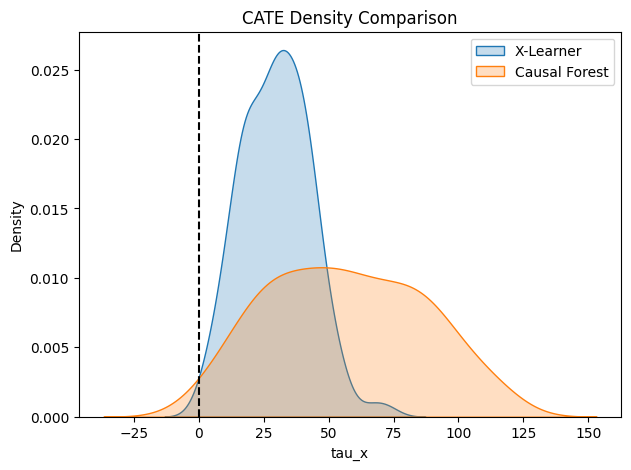

In [ ]:
plt.figure(figsize=(7,5))
sns.kdeplot(df_eval["tau_x"], label="X‑Learner", fill=True)
sns.kdeplot(df_eval["tau_cf"], label="Causal Forest", fill=True)
plt.axvline(0, color="black", linestyle="--")
plt.title("CATE Density Comparison")
plt.legend()
plt.show()


### CATE Density Comparison — Interpretation

The figure shows the **kernel density estimates (KDE)** of the **Conditional Average Treatment Effect (CATE)** distributions produced by:

- **X‑Learner**
- **Causal Forest**

The dashed vertical line at zero represents **no treatment effect**.

---

### Key Observations

- **X‑Learner**
  - The density is **more concentrated** and peaks around moderate positive values.
  - The distribution is relatively **narrow**, indicating **lower variance** in individual treatment effect estimates.
  - Most mass lies well above zero, suggesting a consistently positive estimated treatment effect.

- **Causal Forest**
  - The density is **wider** with a **long right tail**, extending to much larger values.
  - This indicates **stronger heterogeneity** and the presence of individuals with very large estimated treatment effects.
  - The broader spread reflects higher flexibility, but also higher variance.

---

### Interpretation

Both models indicate that the treatment effect is **predominantly positive**, as most of the density lies to the right of zero.  
However, the models differ substantially in how they characterize heterogeneity:

- The **X‑Learner** provides **smoother and more stable** CATE estimates.
- The **Causal Forest** captures **richer and more extreme heterogeneity**, identifying potential high‑response subpopulations.

---

### Conclusion

This density comparison highlights a clear **bias–variance trade‑off**:
- **X‑Learner** favors stability and conservative estimation.
- **Causal Forest** favors flexibility and sensitivity to complex treatment effect patterns.

Such density‑level analysis complements boxplots and summary metrics by revealing the **full distributional behavior** of estimated CATEs.


In [ ]:
df_eval["group"] = (df_eval["bmi"] > df_eval["bmi"].median()).astype(int)


### Subgroup Definition and Interpretation (Two‑Group Comparison)

#### What This Step Does
We split the **evaluation sample** into two subgroups based on a key covariate: **Body Mass Index (BMI)**.

- The split is performed at the **median BMI**.
- Using the median ensures that the two groups are approximately **balanced in size**, which improves the stability and interpretability of subgroup comparisons.

---

#### Group Definition
Let $X_i $ denote the BMI value for individual $ i $, and let  
$ \text{median(BMI)} $ be the sample median.

- **Group 0 (Low BMI)**  
  $$
  X_i \le \text{median(BMI)}
 $$

- **Group 1 (High BMI)**  
 $$
  X_i > \text{median(BMI)}
  $$


In [ ]:
df_eval["group"].value_counts()

,count
group,
0,67
1,66


In [ ]:
df_eval.groupby("group")[["tau_x","tau_cf"]].agg(["mean","std"])

tau_x                tau_cf           
            mean        std       mean        std
group                                            
0      23.663989  11.485502  55.497151  29.570737
1      35.656308  12.290713  57.688712  29.960075

## Subgroup-Specific ATE from CATE Estimates  
### (X‑Learner vs. Causal Forest)

### What This Does
For each subgroup (`group = 0` and `group = 1`), we compute:
- **Mean CATE from X‑Learner** (`tau_x`)
- **Mean CATE from Causal Forest** (`tau_cf`)

These subgroup-wise means correspond to **subgroup-specific Average Treatment Effects (ATEs)**.

In other words, instead of reporting a single global ATE, we estimate how the treatment effect differs **within each subgroup**.

---

### Subgroup Definition
Let $ G_i \in \{0,1\} $ denote subgroup membership for individual $ i $:
- $ G_i = 0 $: High‑BMI subgroup  
- $ G_i = 1 $: Low‑BMI subgroup  

(Defined earlier via a median split on BMI.)

---

### Mathematical Interpretation

For a given subgroup $ g \in \{0,1\} $, the **subgroup ATE** is defined as:
$$
\widehat{\mathrm{ATE}}^{(g)}
=
\frac{1}{n_g}
\sum_{i : G_i = g}
\hat{\tau}(X_i)
$$

where:
- $ n_g $: number of individuals in subgroup $ g $
- $ G_i $: subgroup indicator for individual $ i $
- $ \hat{\tau}(X_i) $: estimated CATE for individual $ i $

---

### Model-Specific Formulation

**X‑Learner**
$$
\widehat{\mathrm{ATE}}^{(g)}_{\text{X‑Learner}}
=
\frac{1}{n_g}
\sum_{i : G_i = g}
\hat{\tau}^{X}_i
$$

**Causal Forest**
$$
\widehat{\mathrm{ATE}}^{(g)}_{\text{Causal Forest}}
=
\frac{1}{n_g}
\sum_{i : G_i = g}
\hat{\tau}^{CF}_i
$$


## Specific Interpretation Based on Corrected Group Definitions (BMI-Based)

### Group Definitions (Explicit)

- **Treatment Group (High BMI)**  
  Individuals with  
  $$
  \text{BMI} > 0.0017505
  $$

- **Control Group (Low BMI)**  
  Individuals with  
  $$
  \text{BMI} \le 0.0017505
  $$

Here:
- **Group 1 = Treatment group (High BMI)**
- **Group 0 = Control group (Low BMI)**

---

## Subgroup-Specific Average Treatment Effects (ATE)

The table reports **average CATE values** within each BMI-defined group.

### X-Learner Results

- **Control (Low BMI)**:  
  $$
  \widehat{\text{ATE}}_{\text{Low BMI}} \approx 23.66
  $$

- **Treatment (High BMI)**:  
 $$
  \widehat{\text{ATE}}_{\text{High BMI}} \approx 35.66
  $$

#### Difference (Treatment − Control)
$$
35.66 - 23.66 \approx \mathbf{+12.0}
$$

**Interpretation**:  
High-BMI individuals experience, on average, a **~12 progression-unit larger treatment effect** than low-BMI individuals according to the X‑Learner.  
This indicates **meaningful treatment effect heterogeneity favoring the treatment (high-BMI) group**.

---

### Causal Forest Results

- **Control (Low BMI)**:  
  $$
  \widehat{\text{ATE}}_{\text{Low BMI}} \approx 55.50
 $$

- **Treatment (High BMI)**:  
  $$
  \widehat{\text{ATE}}_{\text{High BMI}} \approx 57.69
  $$

#### Difference (Treatment − Control)
$$
57.69 - 55.50 \approx \mathbf{+2.2}
$$

**Interpretation**:  
Causal Forest also finds a **positive treatment effect for the high-BMI group**, but the difference is **small**, suggesting **mild heterogeneity**.

---

## Unified Interpretation (Treatment vs. Control)

- The **treatment effect is positive in both BMI groups**, meaning the treatment is beneficial overall.
- **High-BMI individuals benefit more than low-BMI individuals**.
- The magnitude of this advantage depends on the model:
  - **X‑Learner**: strong and practically meaningful difference
  - **Causal Forest**: modest but consistent difference

---

## Summary

> When defining treatment as **BMI above the median (0.0017505)**, both models indicate a positive treatment effect.  
> The X‑Learner estimates a substantially larger effect for the treatment (high‑BMI) group, while the Causal Forest estimates a smaller but still positive difference.  
> Overall, the results provide evidence of **treatment effect heterogeneity**, with **high‑BMI individuals benefiting more from the treatment than low‑BMI individuals**.


##Final Notes on Treatment Assignment : Treatment Assignment Based on BMI (Deterministic Rule)

In this analysis, **treatment assignment is not randomized**.  
Instead, individuals are assigned to groups using a **deterministic rule** based on BMI.

### Group Definition

Let $ X_i $ denote BMI for individual $ i $, and let the sample median be:

$$
\text{Median}_{BMI} = 0.0017505
$$

The groups are defined as:

$$
\begin{aligned}
\textbf{Treatment group (High BMI)} &: X_i > 0.0017505 \\
\textbf{Control group (Low BMI)} &: X_i \le 0.0017505
\end{aligned}
$$

Thus:
- **Group 1** corresponds to individuals with **BMI above the median** (treated)
- **Group 0** corresponds to individuals with **BMI at or below the median** (control)

### Nature of the Treatment Assignment

This assignment mechanism is **deterministic**, meaning:

- Treatment status is a **fixed function of BMI**
- Every individual with BMI above the median is treated
- Every individual with BMI below or equal to the median is untreated
- There is **no randomness** in treatment allocation

Formally, the treatment indicator can be written as:

\[
T_i = \mathbb{1}(X_i > 0.0017505)
\]

### Implications for Causal Interpretation

- The treatment is **endogenously determined** by a covariate (BMI)
- This setup corresponds to **observational data**, not a randomized experiment
- Estimated treatment effects should be interpreted as:
  - **Conditional on BMI-based assignment**
  - Potentially subject to **selection bias** if BMI is correlated with unobserved factors affecting the outcome

Therefore, subgroup-specific CATE estimates in this setting capture **heterogeneity across BMI-defined groups**, rather than causal effects under random treatment assignment.

### Summary

- BMI is used both as a **covariate** and as a **treatment assignment rule**
- Treatment vs. control is defined by a **median split**
- The analysis evaluates how estimated treatment effects differ between
  **low-BMI (control)** and **high-BMI (treated)** individuals under this deterministic design
